### Modules

In [66]:
import pandas as pd
import logging
from youtube_search import YoutubeSearch
from pytubefix import YouTube
from pydub import AudioSegment

import re
import os
import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

os.makedirs('datasets/songs', exist_ok=True)
os.makedirs('datasets/wav_songs', exist_ok=True)

### Variables
```yaml
This module contains the configuration for the youtube search and download
You can change the configuration here

YOUTUBE_BASE_URL: The base url for the youtube search
YOUTUBE_SEARCH_MAX_RESULTS: The maximum number of results to return from the youtube search
YOUTUBE_CLIENT_TYPE: The type of client to use for the youtube search
YOUTUBE_MAX_VIDEO_LENGTH: The maximum length of a video in seconds
YOUTUBE_MIN_VIDEO_LENGTH: The minimum length of a video in seconds

SONG_SIZE_PER_TITLE: size (count) songs per title
SEGMENT_LENGTH: The length of each segment in seconds

LAGU_DAERAH_PATH: The path to the lagu daerah dataset
DOWNLOADED_SONGS_PATH: The path to the downloaded songs
SONGS_WAV_PATH: The path to the songs in wav format
```

In [67]:

YOUTUBE_BASE_URL = 'https://www.youtube.com/watch?v='
YOUTUBE_SEARCH_MAX_RESULTS = 70
YOUTUBE_CLIENT_TYPE='IOS'
YOUTUBE_MAX_VIDEO_LENGTH = 450
YOUTUBE_MIN_VIDEO_LENGTH = 30

SONG_SIZE_PER_TITLE=50
SEGMENT_LENGTH = 30

# LAGU_DAERAH_PATH = 'data/lagu_daerah.csv'
# LAGU_DAERAH_PATH = 'data/lagu_daerah_alternatif.csv'
LAGU_DAERAH_PATH = 'data/lagu_daerah_5.csv'
DOWNLOADED_SONGS_PATH = 'data/downloaded_songs.csv'
SONGS_WAV_PATH = 'data/songs_wav.csv'

### Load Scrapping Result

In [68]:
data = pd.read_csv(LAGU_DAERAH_PATH, sep=',')
data.head()

,nama_lagu,asal
0,Kicir-kicir,Jakarta
1,Ampar-ampar Pisang,Kalimantan Selatan
2,Yamko Rambe Yamko,Papua
3,Apuse,Papua Barat
4,Bengawan Solo,Jawa Tengah


### Search and Download Music Function

In [69]:
import requests

API_BASE_URL = 'http://192.168.1.6:3000'

def search_yt(query, max_results=YOUTUBE_SEARCH_MAX_RESULTS):
    try:
        results = YoutubeSearch(query, max_results).to_dict()
        for result in results:
            result['url'] = YOUTUBE_BASE_URL + result['id']
        return results
    except Exception as e:
        logging.error(f"Error searching YouTube for query '{query}': {e}")
        return []

def search_yt_alternate(query, max_results=YOUTUBE_SEARCH_MAX_RESULTS):
    try:
        res = requests.get(f'{API_BASE_URL}/search-selenium?query={query}&max_results={max_results}')
        
        json = res.json()
        
        return json['videos']
    except Exception as e:
        logging.error(f"Error searching YouTube for query '{query}': {e}")
        return []
    
def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def dl_video(url):
    try:
        yt = YouTube(url)
        logging.info(f'Downloading {yt.title}...')
        
        normalized_title = normalized_yt_title(yt.title)
        
        # check if video already downloaded
        filepath= f'datasets/songs/{normalized_title}.mp3'
        if os.path.exists(filepath):
            logging.info(f'File already exists: {filepath}')
            
            return filepath
        
        audio_stream = yt.streams.get_audio_only()
        
        audio_stream.download(output_path='datasets/songs', filename=normalized_title, mp3=True)
        
        return f'datasets/songs/{normalized_title}.mp3'
    except Exception as e:
        logging.error(f"Error downloading video from URL '{url}': {e}")
        return None
    
def parse_duration(duration_str):
    duration_str = duration_str.replace('.', ':')
    if duration_str.count(':') == 2:
        duration = datetime.datetime.strptime(duration_str, '%H:%M:%S')
    else:
        duration = datetime.datetime.strptime(duration_str, '%M:%S')
        
    return duration.hour * 3600 + duration.minute * 60 + duration.second

In [70]:
dl_results = []

for index, row in data.iterrows():
    # Construct the search keyword
    keyword = f"Lagu Daerah {row['nama_lagu']}"
    # searched_songs = search_yt(keyword)
    searched_songs = search_yt_alternate(keyword)
    
    logging.info(f"Found {len(searched_songs)} results for '{keyword}'")
    if len(searched_songs) < SONG_SIZE_PER_TITLE:
        logging.info(f"Not enough results for '{keyword}', skipping...")
        continue
    
    downloaded_count = 0
    for song in searched_songs:
        if downloaded_count >= SONG_SIZE_PER_TITLE:
            logging.info(f"Downloaded {downloaded_count} songs for '{keyword}'")
            break
        
        # jika judul yt tidak ada match sama sekali dengan kata kata yang dicari, skip
        # if not any(word.lower() in song['title'].lower() for word in keyword.lower().split()):
        #     logging.info(f"Skipping '{song['title']}' as it doesn't match the search keyword")
        #     continue
        
        try:
            duration = parse_duration(song['duration'])
            if duration < YOUTUBE_MAX_VIDEO_LENGTH and duration > YOUTUBE_MIN_VIDEO_LENGTH:                    
                path = dl_video(song['url'])
                if (path == None):
                    continue
                
                # Append the result to downloaded_results list
                dl_results.append({
                    'title': song['title'],
                    'nama_lagu': row['nama_lagu'],
                    'region': row['asal'],
                    'keyword': keyword,
                    'duration': duration,
                    'url': song['url'],
                    'path': path
                })
                logging.info(f"Downloaded: {song['title']} from {song['url']}")
                
                downloaded_count += 1
            else:
                logging.warning(f"Duration of {song['title']} is too long: {duration} seconds")
        except Exception as e:
            logging.error(f"Error processing song {song['title']}: {e}")

2025-01-07 16:51:53,123 - INFO - Found 70 results for 'Lagu Daerah Kicir-kicir'
2025-01-07 16:51:53,270 - INFO - Downloading KICIR KICIR | Lagu Daerah DKI Jakarta - Betawi | Budaya Indonesia | Dongeng Kita...
2025-01-07 16:51:53,271 - ERROR - Error downloading video from URL 'https://www.youtube.com/watch?v=lhZf7qGZzsE': lhZf7qGZzsE is unavailable
2025-01-07 16:51:53,404 - INFO - Downloading KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak...
2025-01-07 16:51:53,405 - ERROR - Error downloading video from URL 'https://www.youtube.com/watch?v=0wTJULU2REc': 0wTJULU2REc is unavailable
2025-01-07 16:51:53,591 - INFO - Downloading Kicir Kicir Jakarta...
2025-01-07 16:51:53,592 - INFO - File already exists: datasets/songs/kicir_kicir_jakarta.mp3
2025-01-07 16:51:53,593 - INFO - Downloaded: Kicir Kicir Jakarta from https://www.youtube.com/watch?v=jMynoFKskhc
2025-01-07 16:51:53,751 - INFO - Downloading Kicir Kicir (Lagu Daerah Betawi)...
2025-01-07 16:51:53,752 - INFO - File already exists: d

In [71]:
# get total
logging.info(f"Total downloaded songs: {len(dl_results)}")

2025-01-07 16:54:10,422 - INFO - Total downloaded songs: 229


### Save list of songs to csv

In [72]:
df = pd.DataFrame(dl_results)

df.to_csv('data/downloaded_songs.csv', index=False)

### Convert to wav format

In [73]:
def convert_to_wav(path):
    if path is None:
        logging.error('File path is None')
        return None
    
    try:
        wav_path = path.replace('songs', 'wav_songs').replace('.mp3', '.wav')
        
        if os.path.exists(wav_path):
            logging.info(f'File already exists: {wav_path}')
            return wav_path
        
        logging.info(f'Converting {path} to {wav_path}')
        
        audio = AudioSegment.from_file(path)
        audio.export(wav_path, format='wav')
        
        return wav_path
    except Exception as e:
        logging.error(f'Exception occurred: {e}')
        return None

In [74]:
df['wav_path'] = df['path'].apply(convert_to_wav)

2025-01-07 16:54:10,451 - INFO - File already exists: datasets/wav_songs/kicir_kicir_jakarta.wav
2025-01-07 16:54:10,452 - INFO - File already exists: datasets/wav_songs/kicir_kicir_lagu_daerah_betawi.wav
2025-01-07 16:54:10,453 - INFO - File already exists: datasets/wav_songs/lirik_lagu_kicir_kicir_lagu_daerah_betawi_by_ceo.wav
2025-01-07 16:54:10,454 - INFO - File already exists: datasets/wav_songs/karaoke_kicir_kicir_lagu_daerah_jakarta.wav
2025-01-07 16:54:10,454 - INFO - Converting datasets/songs/lgm_kicir_kicir.mp3 to datasets/wav_songs/lgm_kicir_kicir.wav
2025-01-07 16:54:11,315 - INFO - File already exists: datasets/wav_songs/juara_1_senam_kreasi_kicir_kicir_se_dki_jakarta.wav
2025-01-07 16:54:11,316 - INFO - File already exists: datasets/wav_songs/orkes_gembira_kicir_kicir.wav
2025-01-07 16:54:11,316 - INFO - File already exists: datasets/wav_songs/eng_cuih_kicir_kicir_gambang_kromong_terpopuler_lagu_khas_betawi_.wav
2025-01-07 16:54:11,317 - INFO - File already exists: datase

In [75]:
df = df[df['wav_path'].notnull()]

In [76]:
df

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,Kicir Kicir Jakarta,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,232,https://www.youtube.com/watch?v=jMynoFKskhc,datasets/songs/kicir_kicir_jakarta.mp3,datasets/wav_songs/kicir_kicir_jakarta.wav
1,Kicir Kicir (Lagu Daerah Betawi),Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,237,https://www.youtube.com/watch?v=CcFbCjM2jsM,datasets/songs/kicir_kicir_lagu_daerah_betawi.mp3,datasets/wav_songs/kicir_kicir_lagu_daerah_bet...
2,Lirik Lagu Kicir Kicir | Lagu Daerah Betawi | ...,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,217,https://www.youtube.com/watch?v=GInHHRrV-6E,datasets/songs/lirik_lagu_kicir_kicir_lagu_dae...,datasets/wav_songs/lirik_lagu_kicir_kicir_lagu...
3,KARAOKE KICIR KICIR Lagu Daerah Jakarta,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,128,https://www.youtube.com/watch?v=nbO8hjzAN20,datasets/songs/karaoke_kicir_kicir_lagu_daerah...,datasets/wav_songs/karaoke_kicir_kicir_lagu_da...
4,Lgm. Kicir - Kicir,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,224,https://www.youtube.com/watch?v=H5TjYdEhpc0,datasets/songs/lgm_kicir_kicir.mp3,datasets/wav_songs/lgm_kicir_kicir.wav
...,...,...,...,...,...,...,...,...
224,Bengawan Solo - Gesang | Alip Ba Ta Feat Orche...,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo,283,https://www.youtube.com/watch?v=eSJTNp9v48Q,datasets/songs/bengawan_solo_gesang_alip_ba_ta...,datasets/wav_songs/bengawan_solo_gesang_alip_b...
225,Bengawan Solo - Linedance #KebayaNyonya# #Keba...,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo,192,https://www.youtube.com/watch?v=UWiDGLBrtJg,datasets/songs/bengawan_solo_linedance_kebayan...,datasets/wav_songs/bengawan_solo_linedance_keb...
226,"BENGAWAN SOLO ""GESANG"" - KERONCONG VERSION || ...",Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo,310,https://www.youtube.com/watch?v=_iAAbKcKej0,datasets/songs/bengawan_solo_gesang_keroncong_...,datasets/wav_songs/bengawan_solo_gesang_keronc...
227,Lagu BENGAWAN SOLO dalam Irama Dansa cover UST...,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo,209,https://www.youtube.com/watch?v=Upu2tU11TB4,datasets/songs/lagu_bengawan_solo_dalam_irama_...,datasets/wav_songs/lagu_bengawan_solo_dalam_ir...


In [77]:
df.to_csv('data/songs_wav.csv', index=False)

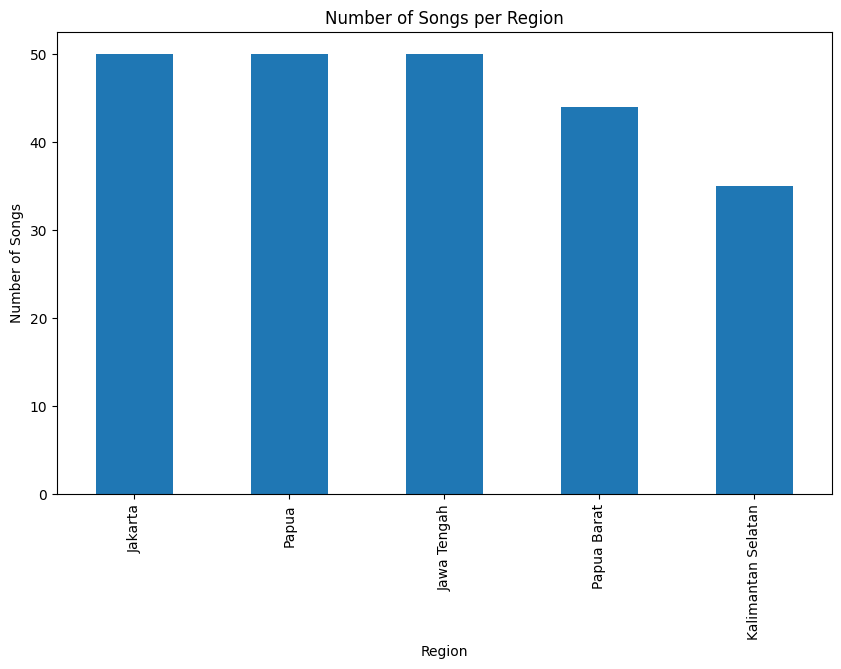

In [78]:
import matplotlib.pyplot as plt

# Count the number of songs per region
region_counts = df['region'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
region_counts.plot(kind='bar')
plt.title('Number of Songs per Region')
plt.xlabel('Region')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.show()